In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from sklearn.cluster import KMeans
sns.set(style="darkgrid")

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

# classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.stats import chisquare, chi2_contingency

In [2]:
# load datasest
df = pd.read_excel("./data/IgM Rapid Test-IgM ELISA-3rd dataset (All are SARS-CoV-2 qPT-PCR positive).xlsx", header=0, comment="#")
len(df)



46

In [3]:
df

,lab-ID,Gender,Age,IgM/Rt,IgM/ODs,IgG/Rt,IgG/ODs,Sym. grade
0,AP1-1,Female,Unknow.,0,0.2,0,0.23,3
1,AP1-2,Female,Unknow.,0,0.34,0,0.37,2
2,AP1-5,Female,61,50,0.35,100,1.77,2
3,AP1-7,Female,39,100,0.67,100,1.46,2
4,AP1-11,Female,71,no,no,no,no,3
5,AP1-12,Female,47,100,0.78,100,1.36,1
6,AP1-13,Female,70,10,0.47,100,1.46,1
7,AP1-16,Female,48,0,0.44,10,0.33,3
8,AP1-23,Female,75,10,0.43,100,1.01,4
9,AP1-28,Female,47,5,0.8,100,1.71,3


In [4]:
# replace unknown with average age
known_age = df[df["Age"] != "Unknow."]
#known_age.boxplot("Age")
avg_age = round(known_age["Age"].mean())
df["Age"] = df["Age"].replace("Unknow.", avg_age)
len(df)

46

In [5]:
# further cleanup
indexNames = df[df['IgM/Rt '] == 'no'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# set age to numeric
df["Age"] = df["Age"].astype(int)

# bin ages
df["Age bin"] = pd.cut(x=df['Age'], 
                       bins=[9, 20, 29, 39, 49, 59, 69, 79, 89], 
                       labels=['10s', '20s', '30s', '40s', '50s','60s', '70s', '80s'])

# remove unwanted spaces

#df[" IgM/Pos."] = df[" IgM/Pos."].str.replace(' ', '')

# remove empty cells
#df = df.dropna(axis=0)
len(df)

45

In [6]:
# create target column
def encode_symptoms(row):
    wanted = row["Sym. grade"]
    if str(wanted) == "0":
        return 0
    return 1

df["target"] = df.apply(encode_symptoms, axis=1)


# create target column
def encode_symptoms(row):
    wanted = row["Sym. grade"]
    if str(wanted) == "0":
        return "no"
    return "yes"

df["symptoms_presence"] = df.apply(encode_symptoms, axis=1)

In [7]:
# Classify status
high_od_IgM = df[df["IgM/ODs"] > 0.498]
low_od_IgM = df[df["IgM/ODs"] <= 0.498]
high_od_IgG = df[df["IgG/ODs"] > 0.542]
low_od_IgG = df[df["IgG/ODs"] <= 0.542]

print("status | number_of_participants")
print("--------------------------")
print(f"high_od_IgM | {len(high_od_IgM)}")
print("--------------------------")
print(f"low_od_IgM | {len(low_od_IgM)}")
print("--------------------------")
print(f"high_od_IgG | {len(high_od_IgG)}")
print("--------------------------")
print(f"low_od_IgG | {len(low_od_IgG)}")


status | number_of_participants
--------------------------
high_od_IgM | 11
--------------------------
low_od_IgM | 34
--------------------------
high_od_IgG | 28
--------------------------
low_od_IgG | 17


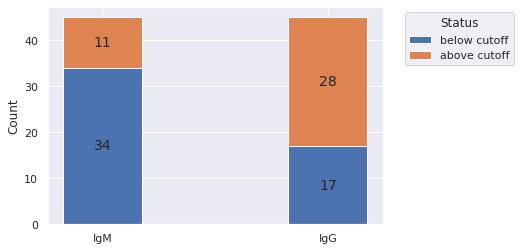

In [8]:
labels = ['IgM', 'IgG']
high = [len(high_od_IgM), len(high_od_IgG)]
low = [len(low_od_IgM), len(low_od_IgG)]
width = 0.35 


fig, ax = plt.subplots()

ax.bar(labels, low, width,
       label='below cutoff')
ax.bar(labels, high, width, bottom=low, label='above cutoff')
ax.set_ylabel('Count')
ax.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')

for i, rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the count value and can used as the label
    label_text = f'{height:.0f}'

    label_x = x + width / 2
    label_y = y + height / 2

    # don't include label if it's equivalently 0
    if height > 0.001:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=14)

plt.show()

In [9]:
def plot_symptoms_status(df_slice):
    count_dict = dict(df_slice["symptoms_presence"].value_counts())
    ax = sns.countplot(x="symptoms_presence", data=df_slice, order=["no", "yes"])
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
    for index, text in enumerate(ax.get_xticklabels()):
        label = count_dict[text.get_text()]
        ax.text(index,
                label + 0.1,
                str(label),
                horizontalalignment='center',
                size='medium',
                color='black',
                weight='normal')
    return plt.show()

High od IgM


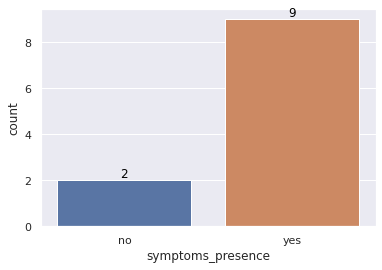

In [13]:
# symptoms status in high od IgM particpants
print("High od IgM")
plot_symptoms_status(high_od_IgM)

High od IgG


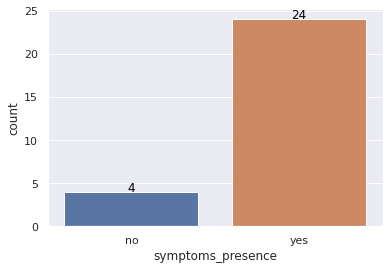

In [14]:
# symptoms status in high od IgG particpants
print("High od IgG")
plot_symptoms_status(high_od_IgG)

low od IgM


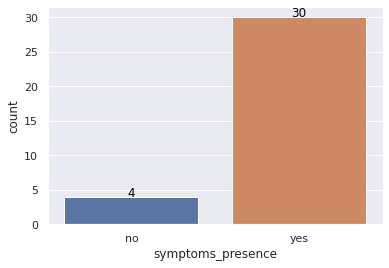

In [12]:
# symptoms status in low od IgM particpants
print("low od IgM")
plot_symptoms_status(low_od_IgM)

low od IgG


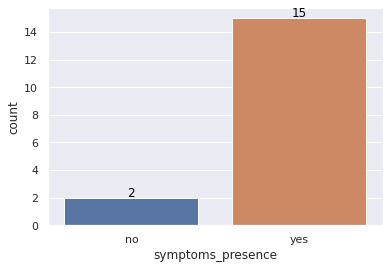

In [97]:
# symptoms status in low od IgG particpants
print("low od IgG")
plot_symptoms_status(low_od_IgG)

In [15]:
# create target 
targets = df["target"].values

# bulk encodings

wanted_columns = ["Gender",
                  "Age bin"]
df_wanted = df[wanted_columns]

le = LabelEncoder()
df_wanted_le = df_wanted.apply(le.fit_transform)
df_wanted_le["IgG_ELISA"] = df["IgG/ODs"]
df_wanted_le["IgM_ELISA"] = df["IgM/ODs"]
df_wanted_le["IgM_rapid_test"] = df["IgM/Rt "]
df_wanted_le["IgG_rapid_test"] = df["IgG/Rt "]


# Generate training and test sets wiht label encoding

X_train, X_test, y_train, y_test = train_test_split(df_wanted_le,
                                                    targets,
                                                    random_state=42)

# Benchmark with dummy classifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
print("dummmy score: {}".format(dummy_clf.score(X_test, y_test)))

# Random forest model

model = RandomForestClassifier(n_jobs=2, random_state=42)
model.fit(X_train, y_train)
print("RF accuracy: {}".format(model.score(X_test, y_test)))

dummmy score: 0.75
RF accuracy: 1.0


<AxesSubplot:>

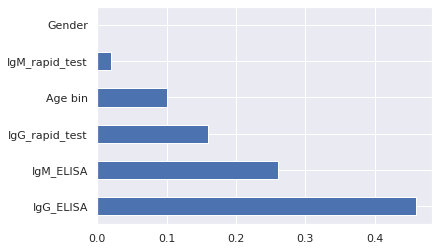

In [17]:
# plot feature contribution to Random forest model -> symtoms presence column
importance = pd.Series(model.feature_importances_, index=df_wanted_le.columns)
importance.nlargest(6).plot(kind='barh')

In [102]:
df

,lab-ID,Gender,Age,IgM/Rt,IgM/ODs,IgG/Rt,IgG/ODs,Sym. grade,Age bin,target,symptoms_presence
0,AP1-1,Female,49,0,0.2,0,0.23,3,40s,1,yes
1,AP1-2,Female,49,0,0.34,0,0.37,2,40s,1,yes
2,AP1-5,Female,61,50,0.35,100,1.77,2,60s,1,yes
3,AP1-7,Female,39,100,0.67,100,1.46,2,30s,1,yes
5,AP1-12,Female,47,100,0.78,100,1.36,1,40s,1,yes
6,AP1-13,Female,70,10,0.47,100,1.46,1,70s,1,yes
7,AP1-16,Female,48,0,0.44,10,0.33,3,40s,1,yes
8,AP1-23,Female,75,10,0.43,100,1.01,4,70s,1,yes
9,AP1-28,Female,47,5,0.8,100,1.71,3,40s,1,yes
10,AP2-4,Female,24,0,0.34,10,0.33,2,20s,1,yes


In [16]:
# Set up different classifiers with label encoder

names = ["K-Nearest Neighbors", "Naive Bayes", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma="scale", C=1),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier()]

# Compare different classifiers

for name, clf in zip(names, classifiers):
    model = clf
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test, y_pred)
    print("###### " + name + " #######")
    print("accuracy: {}".format(accuracy))
    print("report:")
    print(report)
    print("------------------------------\n")


###### K-Nearest Neighbors #######
accuracy: 1.0
report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

------------------------------

###### Naive Bayes #######
accuracy: 0.8333333333333334
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

------------------------------

###### Linear SVM #######
accuracy: 1.0
report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### Random Forest #######
accuracy: 1.0
report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

------------------------------

###### Neural Net #######
accuracy: 1.0
report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

------------------------------

###### AdaBoost #######
accuracy: 0.9166666666666666
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
# Set up different classifiers with one-hot encoder

names = ["K-Nearest Neighbors", "Naive Bayes", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma="scale", C=1),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier()]

# Compare different classifiers

for name, clf in zip(names, classifiers):
    model = clf
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test, y_pred)
    print("###### " + name + " #######")
    print("accuracy: {}".format(accuracy))
    print("report:")
    print(report)
    print("------------------------------\n")


###### K-Nearest Neighbors #######
accuracy: 1.0
report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

------------------------------

###### Naive Bayes #######
accuracy: 0.8333333333333334
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

------------------------------

###### Linear SVM #######
accuracy: 1.0
report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### Neural Net #######
accuracy: 1.0
report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

------------------------------

###### AdaBoost #######
accuracy: 0.9166666666666666
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

------------------------------



/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
